In [1]:
#@title Import libraries

import numpy as np
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt

In [3]:
#@title Mount GDrive, (optional)

COLAB_ENV = True #@param {type:"boolean"}

if COLAB_ENV:
    try:
        from google.colab import drive
        drive.mount("/content/gdrive", force_remount=True)
        from pathlib import Path
    except ModuleNotFoundError:
        COLAB_ENV = False

import os
from contextlib import contextmanager

@contextmanager
def temporary_cd(path):
    """
    Temporarily change the working directory.
    """
    original_path = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(original_path)



In [6]:
PROJECT_PATH = r'C:/xxx'     #Your file path

#with temporary_cd(PROJECT_PATH):
#    print(*[(i_ + ' \n') for i_ in os.listdir(PROJECT_PATH)])

In [7]:
#@title ### Load data

mat_ = loadmat(PROJECT_PATH + '2-PIVlab-1-10.mat')
sorted(mat_.keys())

['LIC',
 '__globals__',
 '__header__',
 '__version__',
 'calu',
 'calv',
 'calxy',
 'correlation_map',
 'divergence',
 'information',
 'shear_rate',
 'strain_rate',
 'typevector_filtered',
 'typevector_original',
 'u_component',
 'u_filtered',
 'u_original',
 'u_smoothed',
 'units',
 'v_component',
 'v_filtered',
 'v_original',
 'v_smoothed',
 'vectorangle',
 'velocity_magnitude',
 'vortex_locator',
 'vorticity',
 'x',
 'y']

In [8]:
u_filtered = mat_['u_original']
v_filtered = mat_['v_original']
x_piv = mat_['x']
y_piv = mat_['y']



print(u_filtered.shape)
print(v_filtered.shape)


print(y_piv.shape)

(29, 31)
(29, 31)
(29, 31)


In [ ]:
# for i_ in u_filtered:
#     print(i_[0].shape)

In [9]:
# Function to determine the most common shape
def find_common_shape(u):
    shapes = [entry.shape for entry in u if entry.size > 0]
    if not shapes:
        raise ValueError("All arrays are empty.")
    # print(set(shapes))
    # Find the most common shape
    most_common_shape = max(set(shapes), key=shapes.count)
    return most_common_shape

# Determine the most common shape
# common_shape = find_common_shape(u_filtered)

# Lambda function to stack arrays with handling for mismatched shapes
stack_arrays = lambda u : np.stack([
    entry if entry.shape == find_common_shape(u) else np.full(find_common_shape(u), np.nan)
    for entry in u
], axis=0)

# Use the lambda function to get the final array
final_array = stack_arrays(u_filtered)

# Check the shape of the final array
print(final_array.shape)


(29, 31)


In [12]:
# u_filtered[0][0].shape

In [10]:
### Fix the arrays

u_filtered = stack_arrays(u_filtered)
v_filtered = stack_arrays(v_filtered)

print(u_filtered.shape)
print(v_filtered.shape)

(29, 31)
(29, 31)


In [12]:
### Read the video

import cv2


# Path to your AVI file
file_path = PROJECT_PATH + 'Mouse-E10.5-anterior-early-dt5-20231116-2-1-trim1-80.avi'

# Create a VideoCapture object
cap = cv2.VideoCapture(file_path)

# Read the first frame to get the dimensions
ret, frame = cap.read()
if not ret:
    print("Failed to read video")
    exit()

# Initialize a list to store the frames
frames = []

# Append the first frame
frames.append(frame)

# Read the rest of the frames
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

# Convert list of frames to a NumPy array
video_array = np.stack(frames)

# Display the shape of the array
print("Shape of the video array: (t, y, x, channels)", video_array.shape)

# Release the video capture object
cap.release()

# Now video_array is a 4D array: (time, height, width, channels)
# If you need a 3D array (grayscale), convert the frames to grayscale:
video_array_gray = np.array([cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames])
print("Shape of the grayscale video array: (t, y, x)", video_array_gray.shape)


Shape of the video array: (t, y, x, channels) (80, 989, 1024, 3)
Shape of the grayscale video array: (t, y, x) (80, 989, 1024)


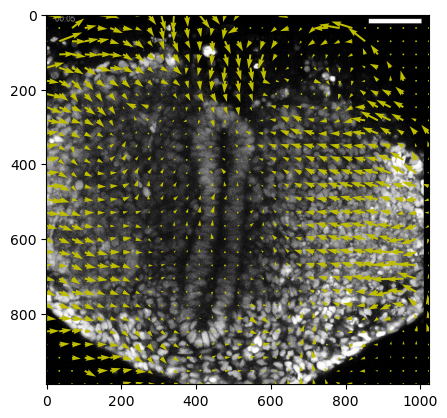

[[   0.    34.1   68.2  102.3  136.4  170.5  204.6  238.7  272.8  306.9
   341.   375.1  409.2  443.3  477.4  511.5  545.6  579.7  613.8  647.9
   682.   716.1  750.2  784.3  818.4  852.5  886.6  920.7  954.8  988.9
  1023. ]
 [   0.    34.1   68.2  102.3  136.4  170.5  204.6  238.7  272.8  306.9
   341.   375.1  409.2  443.3  477.4  511.5  545.6  579.7  613.8  647.9
   682.   716.1  750.2  784.3  818.4  852.5  886.6  920.7  954.8  988.9
  1023. ]
 [   0.    34.1   68.2  102.3  136.4  170.5  204.6  238.7  272.8  306.9
   341.   375.1  409.2  443.3  477.4  511.5  545.6  579.7  613.8  647.9
   682.   716.1  750.2  784.3  818.4  852.5  886.6  920.7  954.8  988.9
  1023. ]
 [   0.    34.1   68.2  102.3  136.4  170.5  204.6  238.7  272.8  306.9
   341.   375.1  409.2  443.3  477.4  511.5  545.6  579.7  613.8  647.9
   682.   716.1  750.2  784.3  818.4  852.5  886.6  920.7  954.8  988.9
  1023. ]
 [   0.    34.1   68.2  102.3  136.4  170.5  204.6  238.7  272.8  306.9
   341.   375.1  409.2  

In [13]:
#Test-plot an overlay of the PIV vectors and the image

import numpy as np
import matplotlib.pyplot as plt

frame_t = 1
# Assuming video_array_gray and u_filtered, v_filtered are defined as mentioned
nl, nc = video_array_gray[frame_t].shape

# Extracting the shape from the filtered arrays for accuracy
nly, nlx = u_filtered.shape

# Use linspace to create exact coordinates, ensuring the endpoint is included
X_ = np.linspace(0, nc-1, nlx)
Y_ = np.linspace(0, nl-1, nly)
X_, Y_ = np.meshgrid(X_, Y_)  # Create a meshgrid based on these exact coordinates


# Display the grayscale image
plt.imshow(video_array_gray[frame_t], cmap='gray')

# Coerce NaN to zero for u and v components
u = np.nan_to_num(u_filtered)
v = np.nan_to_num(v_filtered)

# Quiver plot
plt.quiver(X_, Y_, u, v, color='y', units='dots', angles='xy', scale_units='xy', width=2)
plt.show()
print(X_)

Original shape: (29, 31)
Binned shape: (29, 31)
(29, 31)
(29, 31)
(29, 31)
(29, 31)


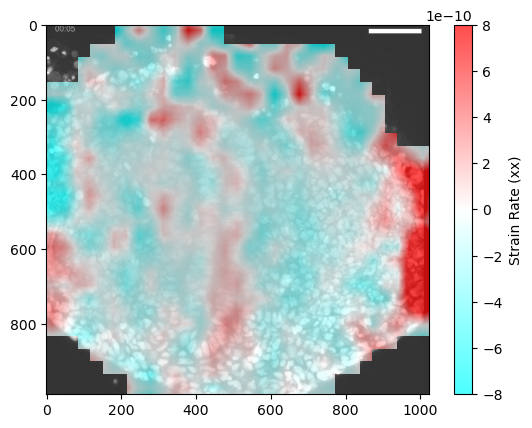

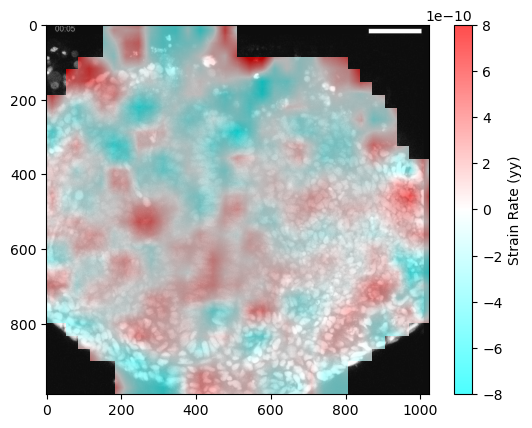

strain rate shape:  (29, 31)


In [14]:
#@title ### Get strain rates, optionally can bin PIV vectors

from matplotlib import rc, animation
from IPython.display import HTML


import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

def bin_meshgrid(X, Y, bin_size):
    """
    Bin the meshgrid arrays X and Y with a given bin_size.
    
    Parameters:
    X (numpy.ndarray): The X-coordinate meshgrid array.
    Y (numpy.ndarray): The Y-coordinate meshgrid array.
    bin_size (int): The size of the bin (e.g., 2 for 2x2 binning).
    
    Returns:
    numpy.ndarray, numpy.ndarray: The binned X and Y meshgrid arrays.
    """
    ny, nx = X.shape
    
    # Calculate the number of rows and columns to remove
    ny_to_remove = ny % bin_size
    nx_to_remove = nx % bin_size
    
    # Adjust the array size by removing rows from the top and columns from the right
    if ny_to_remove != 0:
        X = X[ny_to_remove:, :]
        Y = Y[ny_to_remove:, :]
    if nx_to_remove != 0:
        X = X[:, :-nx_to_remove]
        Y = Y[:, :-nx_to_remove]
    
    # New dimensions after adjustment
    ny_new, nx_new = X.shape
    
    # Reshape and bin
    X_binned = X.reshape(ny_new // bin_size, bin_size, nx_new // bin_size, bin_size).mean(axis=(1, 3))
    Y_binned = Y.reshape(ny_new // bin_size, bin_size, nx_new // bin_size, bin_size).mean(axis=(1, 3))
    
    return X_binned, Y_binned

# Bin the meshgrid
X_binned, Y_binned = bin_meshgrid(X_, Y_, 1)

def bin_array(arr, bin_size):
    """
    Bin an array `arr` with a given `bin_size`.
    
    Parameters:
    arr (numpy.ndarray): The input array of shape (time, y, x).
    bin_size (int): The size of the bin (e.g., 2 for 2x2 binning).
    
    Returns:
    numpy.ndarray: The binned array.
    """
    y, x = arr.shape
    
    # Calculate the number of rows and columns to remove
    y_to_remove = y % bin_size
    x_to_remove = x % bin_size
    
    # Adjust the array size by removing rows from the top and columns from the right
    if y_to_remove != 0:
        arr = arr[y_to_remove:, :]
    if x_to_remove != 0:
        arr = arr[:, :-x_to_remove]
    
    # New dimensions after adjustment
    y_new, x_new = arr.shape[0], arr.shape[1]
    
    # Reshape and aggregate
    new_shape = (y_new // bin_size, bin_size, x_new // bin_size, bin_size)
    binned_arr = arr.reshape(new_shape).mean(axis=(1, 3))
    
    return binned_arr

# Assuming u_filtered has dimensions (81, 29, 31)
# Bin PIV vectors
u_filtered_binned = bin_array(u_filtered, 1)
v_filtered_binned = bin_array(v_filtered, 1)

print("Original shape:", u_filtered.shape)
print("Binned shape:", u_filtered_binned.shape)


strain_rates_xx = np.gradient(u_filtered_binned, axis = -1)
print(strain_rates_xx.shape)
strain_rates_yy = np.gradient(v_filtered_binned, axis = -2)
print(strain_rates_yy.shape)

strain_rates_xy_ = np.gradient(u_filtered_binned, axis = -2)
print(strain_rates_xy_.shape)
strain_rates_yx_ = np.gradient(v_filtered_binned, axis = -1)
print(strain_rates_yx_.shape)

# Symmetrize the strain tensor:
strain_rates_xy = strain_rates_yx = 0.5 * (strain_rates_xy_ + strain_rates_yx_)


from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the modified 'bwr' colormap
# Transparent in the middle
colors = [(0, 1, 1), (1, 1, 1), (1, 0, 0)]  # Blue to transparent to red
positions = [0, 0.5, 1]  # Position of each color

# Create the colormap
bwr_transparent = LinearSegmentedColormap.from_list("bwr_transparent", list(zip(positions, colors)))


strain_rates_xx_resize = resize(strain_rates_xx,
                        output_shape= video_array_gray[5].shape,
                        order = 1) # or set to 1 is want smooth
strain_rates_yy_resize = resize(strain_rates_yy,
                        output_shape= video_array_gray[5].shape,
                        order = 1) # or set to 1 is want smooth
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the grayscale video frame
im1 = ax.imshow(video_array_gray[1], cmap='gray', alpha=0.8)

# Overlay the strain rates plot
im2 = ax.imshow(strain_rates_xx_resize, 
                vmin=-8e-10, vmax=8e-10, 
                cmap=bwr_transparent, alpha=0.7)

# Add a colorbar for the strain rates plot
cbar = plt.colorbar(im2, ax=ax)
cbar.set_label('Strain Rate (xx)')
fig.canvas.draw()
plt.savefig('1hr-xx.png', dpi=600)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the grayscale video frame
im1 = ax.imshow(video_array_gray[1], cmap='gray', alpha=0.95)

# Overlay the strain rates plot
im2 = ax.imshow(strain_rates_yy_resize, 
                vmin=-8e-10, vmax=8e-10, 
                cmap=bwr_transparent, alpha=0.7)

# Add a colorbar for the strain rates plot
cbar = plt.colorbar(im2, ax=ax)
cbar.set_label('Strain Rate (yy)')
fig.canvas.draw()
plt.savefig('1hr-yy.png', dpi=600)
# Show the plot
plt.show()
#plt.imshow(strain_rates_xx,
#           vmin = -1e-9, vmax = 1e-9,
#           cmap = bwr_transparent, alpha = 0.95)
#im = ax.imshow(video_array_gray[11], cmap='gray', alpha = 0.8)
print("strain rate shape: ",strain_rates_xx.shape)


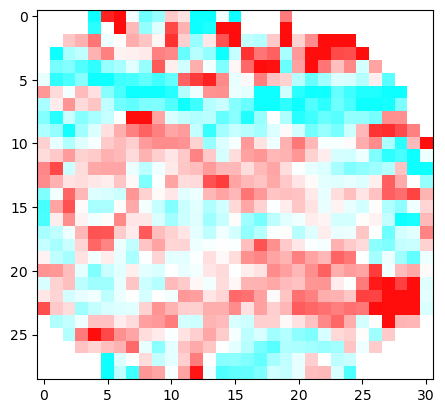

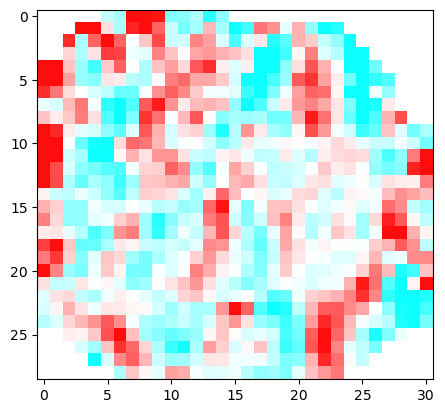

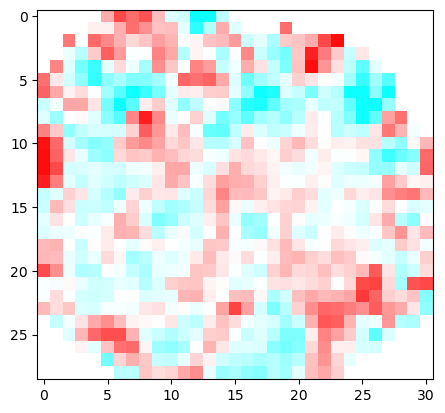

In [16]:
#@title Check shear strain rates


plt.imshow(strain_rates_xy_,
           vmin = -5e-10, vmax = 5e-10,
           cmap = bwr_transparent, alpha = 0.95)
plt.show()


plt.imshow(strain_rates_yx_,
           vmin = -5e-10, vmax = 5e-10,
           cmap = bwr_transparent, alpha = 0.95)
plt.show()


plt.imshow(strain_rates_xy,
           vmin = -5e-10, vmax = 5e-10,
           cmap = bwr_transparent, alpha = 0.95)
plt.show()

In [17]:
#@title ### Get principal strains

#@title plot principal strains

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# # Dummy data for demonstration
# num_points = 10  # Number of tracking points
# DF_00 = np.random.rand(num_points)  # Dummy strain data
# DF_11 = np.random.rand(num_points)
# DF_01 = np.random.rand(num_points)
# DF_10 = np.random.rand(num_points)
# X = np.linspace(0, 10, num_points)  # Dummy X positions
# Y = np.linspace(0, 10, num_points)  # Dummy Y positions

# X_0_positions, Y_0_positions = traj_x_coords[:,0], traj_y_coords[:,0]



import numpy as np

# Function to calculate principal strains and their directions
def get_principal_strains(DF_00, DF_11, DF_01, DF_10):

    #Coerce NaN to zero for u and v components
    DF_00, DF_11, DF_01, DF_10 = np.nan_to_num(DF_00), np.nan_to_num(DF_11), np.nan_to_num(DF_01), np.nan_to_num(DF_10)

    ny, nx = DF_00.shape
    print(DF_00.shape)
    principal_strains = np.zeros((ny, nx, 2))  # 2 for two eigenvalues at each point
    principal_directions = np.zeros((ny, nx, 2, 2))  # 2x2 matrix for eigenvectors at each point

    for i in range(ny):
        for j in range(nx):
            strain_tensor = np.array([[DF_00[i, j], DF_01[i, j]],
                                      [DF_10[i, j], DF_11[i, j]]])

            # Compute eigenvalues and eigenvectors
            eigenvalues, eigenvectors = np.linalg.eig(strain_tensor)

            # Sort the eigenvalues in descending order and get the indices
            sorted_indices = np.argsort(eigenvalues)[::-1]

            # Store sorted eigenvalues and corresponding eigenvectors
            principal_strains[i, j] = eigenvalues[sorted_indices]
            principal_directions[i, j] = eigenvectors[:, sorted_indices]

    return principal_strains, principal_directions

# Example use:
# principal_strains, principal_directions = get_principal_strains(strain_rates_xx, strain_rates_yy, strain_rates_xy, strain_rates_yx)

# Calculate principal strains and directions
principal_strains, principal_directions = get_principal_strains(strain_rates_xx, strain_rates_yy, strain_rates_xy, strain_rates_yx)
print(principal_strains.shape)
print(principal_directions.shape)

(29, 31)
(29, 31, 2)
(29, 31, 2, 2)


(899,)


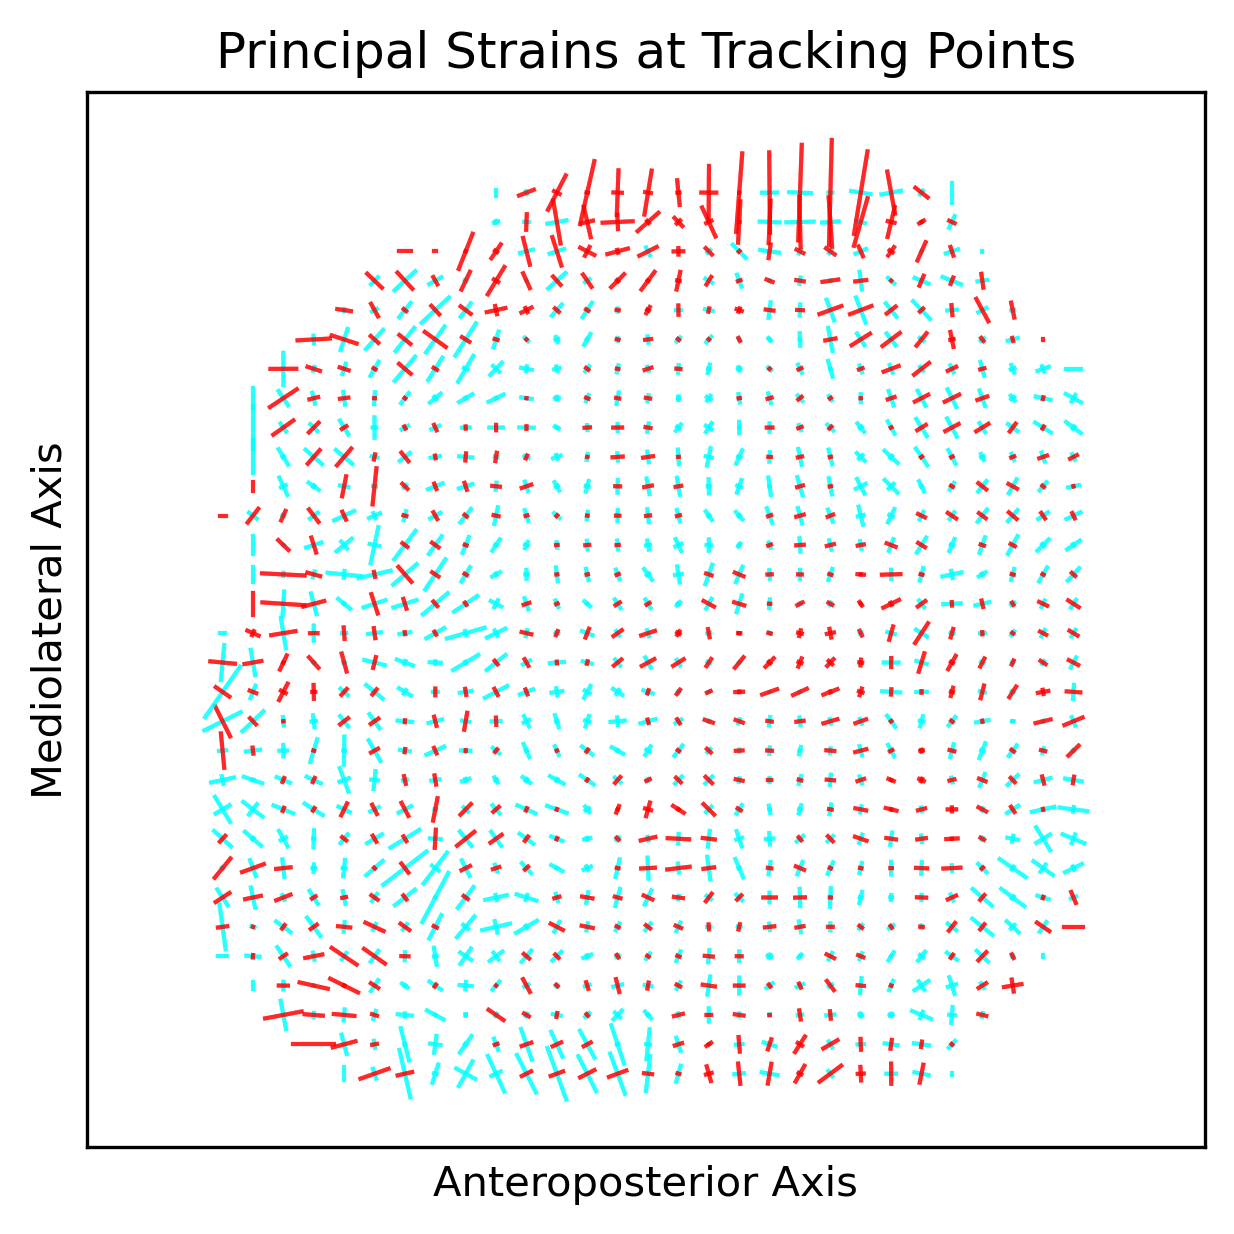

In [18]:
#@title ### Plot principal strains

X_0_positions, Y_0_positions = X_binned.flatten() , Y_binned.flatten()
print(X_0_positions.shape)

def plot_principal_strains(principal_strains, principal_directions, X_0_positions, Y_0_positions,
                           PLOT_SCALING_FACTOR = 150, return_axes = False, fig_axes = None, alpha_ = 1,
                           return_artists = False):
    # Plotting
    if fig_axes == None:
        fig, axes = plt.subplots(1,1,figsize=(4, 4), dpi = 300, layout = 'constrained')
    else:
        fig, axes = fig_axes
    cmap = LinearSegmentedColormap.from_list("red_cyan", ["red", "cyan"])
    #cmap = plt.get_cmap('coolwarm')

    # norm = mcolors.Normalize(vmin=np.min(DF_00), vmax=np.max(DF_11))

    # Setting vmin and vmax for the colormap based on the range of principal strain values
    # vmin = min([min(strains) for strains in scaled_principal_strains])
    # vmax = max([max(strains) for strains in scaled_principal_strains])

    vmin, vmax = -1e-9, 1e-9

    # Update the norm with the new vmin and vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    artists = []  # List to store artist objects

    # PLOT_SCALING_FACTOR  = 150.0

    for idx_i in range(principal_strains.shape[0]):
        for idx_j in np.arange(principal_strains.shape[1])[::-1]: # do inverse order so that large eigval plots las t i.e. on top of the small
            idx_j = int(idx_j)
            strain = principal_strains[idx_i][idx_j]
            direction = principal_directions[idx_i][:, idx_j]
            # Calculate the start and end points to center the line segment around (X[idx_i], Y[idx_i])
            start_point = np.array([X_0_positions[idx_i], Y_0_positions[idx_i]]) - direction * strain / 2 * PLOT_SCALING_FACTOR
            end_point = np.array([X_0_positions[idx_i], Y_0_positions[idx_i]]) + direction * strain / 2 * PLOT_SCALING_FACTOR
            # # Calculate the start and end points to center the line segment around (X[idx_i], Y[idx_i])
            # # DO NOT SCALE BY STRAIN
            # start_point = np.array([X[i], Y[i]]) - direction / 2 * PLOT_SCALING_FACTOR
            # end_point = np.array([X[i], Y[i]]) + direction / 2 * PLOT_SCALING_FACTOR

            # axes.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]],
            #         color=cmap(norm(strain)), linewidth= 0.75 * strain * PLOT_SCALING_FACTOR / 30)

            color_ = 'red' if strain > 0 else 'cyan'
            axes.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                    color= color_, linewidth= 1.0,  alpha = alpha_ )


            line = axes.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                             color=color_, linewidth=1.0, alpha=alpha_)

            artists.append(line[0])  # Store the Line2D object

    if return_artists:
        return artists


    # plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax = axes, label='Principal Strain Magnitude')
    plt.title('Principal Strains at Tracking Points')
    plt.xlabel('Anteroposterior Axis')
    plt.ylabel('Mediolateral Axis')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

    # plt.grid(True)
    plt.axis('equal')
    ax = plt.gca()
    ax.set_facecolor("white") #black


    if return_axes:
        return fig, axes
    else:
        return fig

    
#rotated_frame = np.rot90(video_array_gray[11])

# Create a figure and axis
#fig, ax = plt.subplots()

# Plot the grayscale video frame
#im1 = ax.imshow(rotated_frame, cmap='gray', alpha=0.95)

# Overlay the strain rates plot
im2 = plot_principal_strains(principal_strains.reshape(-1, 2), principal_directions.reshape(-1, 2, 2), X_0_positions, Y_0_positions,PLOT_SCALING_FACTOR = 5e10,alpha_ = 0.6)

fig.canvas.draw()
plt.savefig('6-10hr-principal_strains.png', dpi=600)

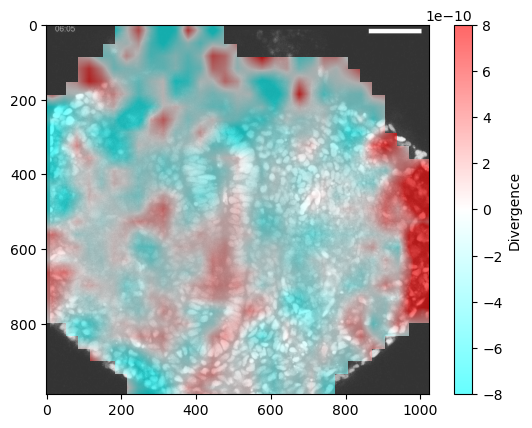

In [19]:
#@title  Compute divergence
divergence = strain_rates_xx + strain_rates_yy  # ∂u/∂x + ∂v/∂y
ax.clear()
# Create a figure and axis
fig, ax = plt.subplots()
im = ax.imshow(video_array_gray[73], cmap='gray', alpha = 0.8)
divergence_im = resize(divergence,
                        output_shape= video_array_gray[15].shape,
                        order = 1) # or set to 1 is want smooth

div_im = ax.imshow(divergence_im,
            vmin = -8e-10, vmax = 8e-10, #adjust for scale
            cmap = bwr_transparent, alpha = 0.6)
cbar = plt.colorbar(div_im, ax=ax)
cbar.set_label('Divergence')
fig.canvas.draw()
plt.savefig('6-10hr-div.png', dpi=600)
plt.show()